In [1]:
import pandas as pd
import numpy as np
import argparse
import itertools

import re
import os
from os import path
import sys
import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

#%load_ext autoreload
#%autoreload 2
    
# Linux dvfs policies: https://www.kernel.org/doc/Documentation/cpu-freq/governors.txt
policies = ["ondemand"]

# total time to run for, in ms
times = [300000]

# diff flink rates
rates = [100, 200, 300, 400]

mappers = [4, 8, 12, 16, 24, 32, 64]
sources = [4, 8, 12, 16, 24, 32, 64]
sinks = [4, 8, 12, 16, 24, 32, 64]

df_dict = {
    'rate': [], 'policy': [], 'pkg_watts_avg': [], 'pkg_watts_std': [], 'dram_watts_avg': [], 'dram_watts_std': [],
    'source': [], 'mapper':[], 'sink':[],
    
    'SinknumRecordsInPerSecond_avg': [], 'SinknumRecordsInPerSecond_std': [], 
    'SinknumRecordsOutPerSecond_avg': [], 'SinknumRecordsOutPerSecond_std': [], 
    'SinkbusyTimeMsPerSecond_avg': [], 'SinkbusyTimeMsPerSecond_std': [], 
    'SinkbackPressuredTimeMsPerSecond_avg': [], 'SinkbackPressuredTimeMsPerSecond_std': [], 
    'SinkbusyTime_%': [], 'SinkbackPressuredTime_%': [], 

    'SourcenumRecordsInPerSecond_avg': [], 'SourcenumRecordsInPerSecond_std': [], 
    'SourcenumRecordsOutPerSecond_avg': [], 'SourcenumRecordsOutPerSecond_std': [], 
    'SourcebusyTimeMsPerSecond_avg': [], 'SourcebusyTimeMsPerSecond_std': [], 
    'SourcebackPressuredTimeMsPerSecond_avg': [], 'SourcebackPressuredTimeMsPerSecond_std': [], 
    'SourcebusyTime_%': [], 'SourcebackPressuredTime_%': [], 

    'MappernumRecordsInPerSecond_avg': [], 
    'MappernumRecordsInPerSecond_std': [], 'MappernumRecordsOutPerSecond_avg': [], 
    'MappernumRecordsOutPerSecond_std': [], 'MapperbusyTimeMsPerSecond_avg': [], 
    'MapperbusyTimeMsPerSecond_std': [], 'MapperbackPressuredTimeMsPerSecond_avg': [], 
    'MapperbackPressuredTimeMsPerSecond_std': [],
    'MapperbusyTime_%': [], 'MapperbackPressuredTime_%': []
}

def resetdict():
    for key in df_dict:
       df_dict[key] = []

/tmp/ipykernel_2049974/468294962.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
def parseFile(loc, rate, policy, mapper, source, sink, timems):
    file=f"{loc}/summary.csv"
    
    df_dict['mapper'].append(mapper)    
    df_dict['source'].append(source) 
    df_dict['sink'].append(sink) 
    df_dict['policy'].append(policy)
    df_dict['rate'].append(rate)
        
    df = pd.read_csv(file)
    df = df[df.columns.drop(list(df.filter(regex='Cnt')))]
    df = df[df.columns.drop(list(df.filter(regex='Bytes')))]
    
    dff = df[df['name'].str.contains('Sink')]
    dff.columns = 'Sink' + dff.columns
    cols = dff.columns
    for col in cols[2:]:
        df_dict[col].append(dff.mean(numeric_only=True)[col])

    dff = df[df['name'].str.contains('Source')]
    dff.columns = 'Source' + dff.columns
    cols = dff.columns
    for col in cols[2:]:
        df_dict[col].append(dff.mean(numeric_only=True)[col])

    dff = df[df['name'].str.contains('Mapper')]
    dff.columns = 'Mapper' + dff.columns
    cols = dff.columns
    for col in cols[2:]:
        df_dict[col].append(dff.mean(numeric_only=True)[col])

    # server2_rapl.log collects Power (energy/second) data
    jfile = f"{loc}/rapl.log"
    with open(jfile) as file:
        pkg = []
        dram = []
        for line in file:
            pkg.append(float(line.strip().split(' ')[0]))
            dram.append(float(line.strip().split(' ')[1]))
        # extract values from 40%-80% of total time to account for warmup time and capture region of compute
        time_in_secs = timems/1000
        stime = int(time_in_secs * 0.4)
        etime = int(time_in_secs * 0.8)
    
        # get the average Power within this timeslot
        df_dict['pkg_watts_avg'].append(float(round(np.mean(pkg[stime:etime]), 2)))
        df_dict['pkg_watts_std'].append(float(round(np.mean(pkg[stime:etime]), 2)))
        df_dict['dram_watts_avg'].append(float(round(np.mean(dram[stime:etime]), 2)))
        df_dict['dram_watts_std'].append(float(round(np.mean(dram[stime:etime]), 2)))


In [4]:
resetdict()
combinations = list(itertools.product(policies, rates, times, mappers, sources, sinks))
for combo in combinations:
    policy, rate, timems, mapper, source, sink = combo

    loc=f"../logs/imgproc_cores16_frate{rate}_{timems}_fbuff-1_itr1_ondemanddvfs1_source{source}_mapper{mapper}_sink{sink}_repeat0"
    if not path.exists(loc+ "/summary.csv"):
        continue
    print(loc)
    parseFile(loc, rate, policy, mapper, source, sink, timems)
#    print(len(dd1.index))    
#    dd1.to_csv(f"{loc1}/combined.csv", mode='w')

../logs/imgproc_cores16_frate100_300000_fbuff-1_itr1_ondemanddvfs1_source4_mapper4_sink4_repeat0
../logs/imgproc_cores16_frate100_300000_fbuff-1_itr1_ondemanddvfs1_source4_mapper4_sink8_repeat0
../logs/imgproc_cores16_frate100_300000_fbuff-1_itr1_ondemanddvfs1_source4_mapper4_sink12_repeat0
../logs/imgproc_cores16_frate100_300000_fbuff-1_itr1_ondemanddvfs1_source4_mapper4_sink16_repeat0
../logs/imgproc_cores16_frate100_300000_fbuff-1_itr1_ondemanddvfs1_source4_mapper4_sink24_repeat0
../logs/imgproc_cores16_frate100_300000_fbuff-1_itr1_ondemanddvfs1_source4_mapper4_sink32_repeat0
../logs/imgproc_cores16_frate100_300000_fbuff-1_itr1_ondemanddvfs1_source4_mapper4_sink64_repeat0
../logs/imgproc_cores16_frate100_300000_fbuff-1_itr1_ondemanddvfs1_source8_mapper4_sink4_repeat0
../logs/imgproc_cores16_frate100_300000_fbuff-1_itr1_ondemanddvfs1_source8_mapper4_sink8_repeat0
../logs/imgproc_cores16_frate100_300000_fbuff-1_itr1_ondemanddvfs1_source8_mapper4_sink12_repeat0
../logs/imgproc_cores16_

In [5]:
df = pd.DataFrame(df_dict)
print(df.columns)


Index(['rate', 'policy', 'pkg_watts_avg', 'pkg_watts_std', 'dram_watts_avg',
       'dram_watts_std', 'source', 'mapper', 'sink',
       'SinknumRecordsInPerSecond_avg', 'SinknumRecordsInPerSecond_std',
       'SinknumRecordsOutPerSecond_avg', 'SinknumRecordsOutPerSecond_std',
       'SinkbusyTimeMsPerSecond_avg', 'SinkbusyTimeMsPerSecond_std',
       'SinkbackPressuredTimeMsPerSecond_avg',
       'SinkbackPressuredTimeMsPerSecond_std', 'SinkbusyTime_%',
       'SinkbackPressuredTime_%', 'SourcenumRecordsInPerSecond_avg',
       'SourcenumRecordsInPerSecond_std', 'SourcenumRecordsOutPerSecond_avg',
       'SourcenumRecordsOutPerSecond_std', 'SourcebusyTimeMsPerSecond_avg',
       'SourcebusyTimeMsPerSecond_std',
       'SourcebackPressuredTimeMsPerSecond_avg',
       'SourcebackPressuredTimeMsPerSecond_std', 'SourcebusyTime_%',
       'SourcebackPressuredTime_%', 'MappernumRecordsInPerSecond_avg',
       'MappernumRecordsInPerSecond_std', 'MappernumRecordsOutPerSecond_avg',
       'Map

In [28]:
df100 = df[((df.SourcenumRecordsOutPerSecond_avg/df.rate) >= 0.95) & (df.rate == 100) & (df.pkg_watts_avg > 0) & (df.dram_watts_avg > 0)][['rate', 'source', 'mapper', 'sink', 'pkg_watts_avg', 'dram_watts_avg', 'SourcenumRecordsOutPerSecond_avg']]
df100

,rate,source,mapper,sink,pkg_watts_avg,dram_watts_avg,SourcenumRecordsOutPerSecond_avg
0,100,4,4,4,17.43,2.65,97.532205
1,100,4,4,8,17.50,2.79,100.031400
2,100,4,4,12,17.64,2.72,99.948148
3,100,4,4,16,17.14,2.75,100.004167
4,100,4,4,24,17.57,2.74,100.000000
...,...,...,...,...,...,...,...
284,100,24,64,8,58.29,7.71,100.000000
286,100,24,64,16,57.31,7.51,100.012023
287,100,24,64,24,57.81,7.85,100.000000
288,100,24,64,32,57.55,7.91,99.948112


In [32]:
df200 = df[((df.SourcenumRecordsOutPerSecond_avg/df.rate) >= 0.95) & (df.rate == 200) & (df.pkg_watts_avg > 0) & (df.dram_watts_avg > 0)][['rate', 'source', 'mapper', 'sink', 'pkg_watts_avg', 'dram_watts_avg', 'SourcenumRecordsOutPerSecond_avg']]
df200

,rate,source,mapper,sink,pkg_watts_avg,dram_watts_avg,SourcenumRecordsOutPerSecond_avg
297,200,4,4,4,28.36,4.84,200.021065
298,200,4,4,8,31.58,5.07,199.980556
299,200,4,4,12,25.67,4.03,200.000000
300,200,4,4,16,30.15,4.96,200.063889
301,200,4,4,24,28.67,4.97,199.790577
...,...,...,...,...,...,...,...
574,200,16,64,12,71.89,9.31,200.036373
575,200,16,64,16,73.17,9.51,200.055266
576,200,16,64,24,72.95,9.51,199.990856
577,200,16,64,32,73.80,9.38,200.071181


In [33]:
df300 = df[((df.SourcenumRecordsOutPerSecond_avg/df.rate) >= 0.95) & (df.rate == 300) & (df.pkg_watts_avg > 0) & (df.dram_watts_avg > 0)][['rate', 'source', 'mapper', 'sink', 'pkg_watts_avg', 'dram_watts_avg', 'SourcenumRecordsOutPerSecond_avg']]
df300

,rate,source,mapper,sink,pkg_watts_avg,dram_watts_avg,SourcenumRecordsOutPerSecond_avg
593,300,4,4,4,38.61,5.96,299.501157
594,300,4,4,8,38.58,5.99,299.527315
595,300,4,4,12,38.41,6.02,299.837582
596,300,4,4,16,39.32,6.00,298.931441
597,300,4,4,24,39.11,6.00,299.485090
...,...,...,...,...,...,...,...
861,300,12,64,4,77.83,10.18,299.984432
864,300,12,64,16,77.33,10.05,299.961760
865,300,12,64,24,78.79,10.23,300.036855
866,300,12,64,32,79.92,10.27,299.965854


In [34]:
df400 = df[((df.SourcenumRecordsOutPerSecond_avg/df.rate) >= 0.95) & (df.rate == 400) & (df.pkg_watts_avg > 0) & (df.dram_watts_avg > 0)][['rate', 'source', 'mapper', 'sink', 'pkg_watts_avg', 'dram_watts_avg', 'SourcenumRecordsOutPerSecond_avg']]
df400

,rate,source,mapper,sink,pkg_watts_avg,dram_watts_avg,SourcenumRecordsOutPerSecond_avg
891,400,4,4,12,43.25,6.70,382.240142
893,400,4,4,24,42.62,6.66,384.459722
894,400,4,4,32,42.63,6.66,382.607870
933,400,4,8,4,42.30,6.58,399.875231
934,400,4,8,8,42.10,6.80,400.159259
...,...,...,...,...,...,...,...
1152,400,8,64,12,70.48,9.40,399.960246
1153,400,8,64,16,71.27,9.34,399.992477
1154,400,8,64,24,70.86,9.35,399.908333
1155,400,8,64,32,69.70,9.22,399.919560


# Experiment Configuration

```
rates = [100, 200, 300, 400]

mappers = [4, 8, 12, 16, 24, 32, 64]
sources = [4, 8, 12, 16, 24, 32, 64]
sinks = [4, 8, 12, 16, 24, 32, 64]
```

# Imgproc Rate 100
## All combinations of [sources, mappers, sinks] that where SourceRecordsOutPerSecond satisfies input rate of 100

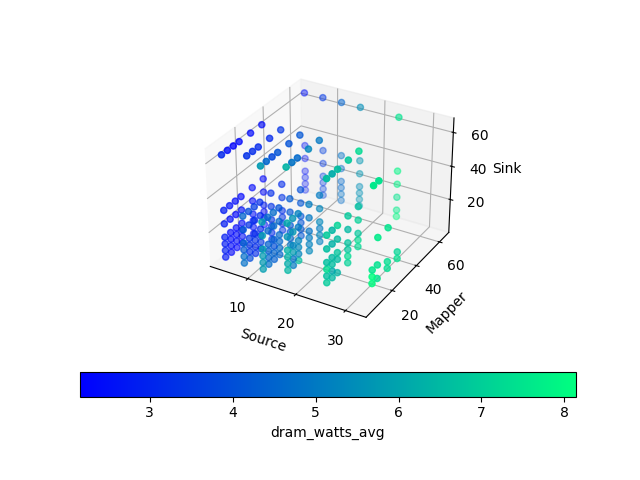

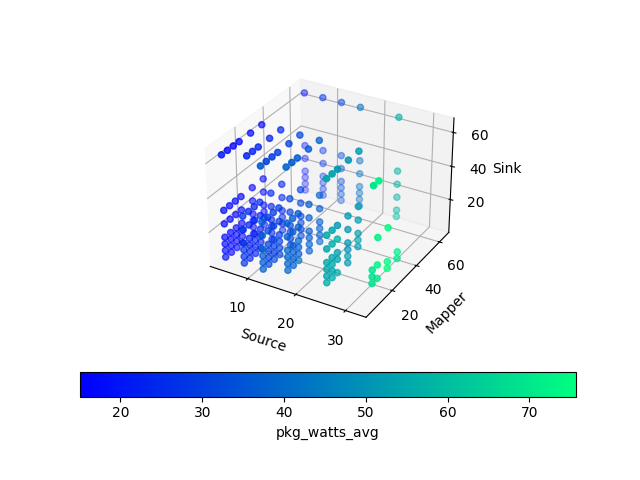

In [43]:
# Creating a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(df100['source'], df100['mapper'], df100['sink'], c=df100['pkg_watts_avg'], cmap=plt.winter())
fig.colorbar(img, orientation="horizontal", pad=0.1, label='pkg_watts_avg')
ax.set_xlabel('Source')
ax.set_ylabel('Mapper')
ax.set_zlabel('Sink')

fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')
img = ax.scatter(df100['source'], df100['mapper'], df100['sink'], c=df100['dram_watts_avg'], cmap=plt.winter())
fig2.colorbar(img, orientation="horizontal", pad=0.1, label='dram_watts_avg')
ax.set_xlabel('Source')
ax.set_ylabel('Mapper')
ax.set_zlabel('Sink')

plt.show()

# Imgproc Rate 200
## All combinations of [sources, mappers, sinks] that where SourceRecordsOutPerSecond satisfies input rate of 200

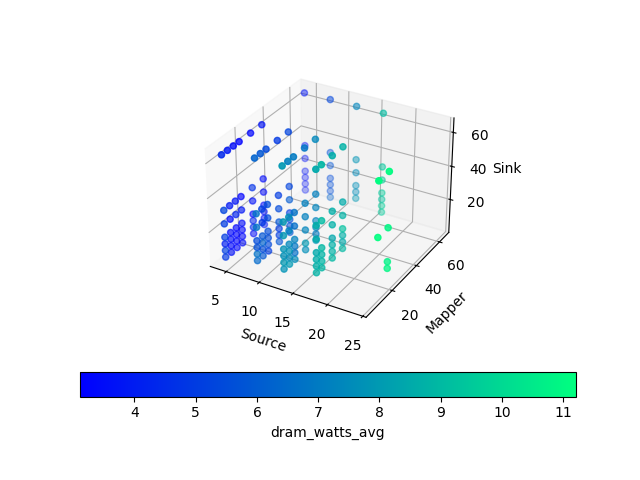

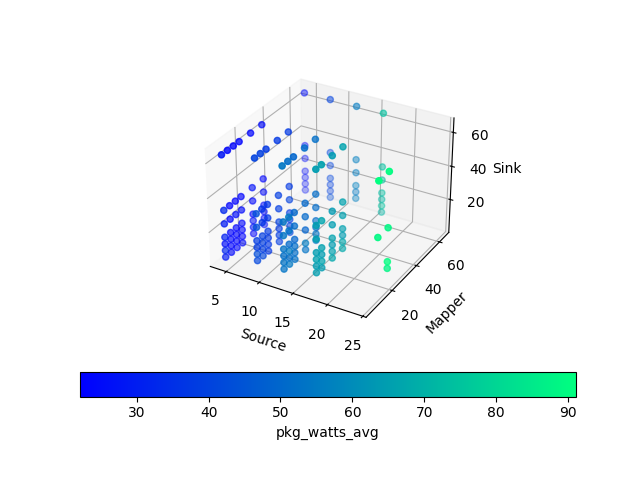

In [42]:
# Creating a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(df200['source'], df200['mapper'], df200['sink'], c=df200['pkg_watts_avg'], cmap=plt.winter())
fig.colorbar(img, orientation="horizontal", pad=0.1, label='pkg_watts_avg')
ax.set_xlabel('Source')
ax.set_ylabel('Mapper')
ax.set_zlabel('Sink')

fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')
img = ax.scatter(df200['source'], df200['mapper'], df200['sink'], c=df200['dram_watts_avg'], cmap=plt.winter())
fig2.colorbar(img, orientation="horizontal", pad=0.1, label='dram_watts_avg')
ax.set_xlabel('Source')
ax.set_ylabel('Mapper')
ax.set_zlabel('Sink')

plt.show()

# Imgproc Rate 300
## All combinations of [sources, mappers, sinks] that where SourceRecordsOutPerSecond satisfies input rate of 300

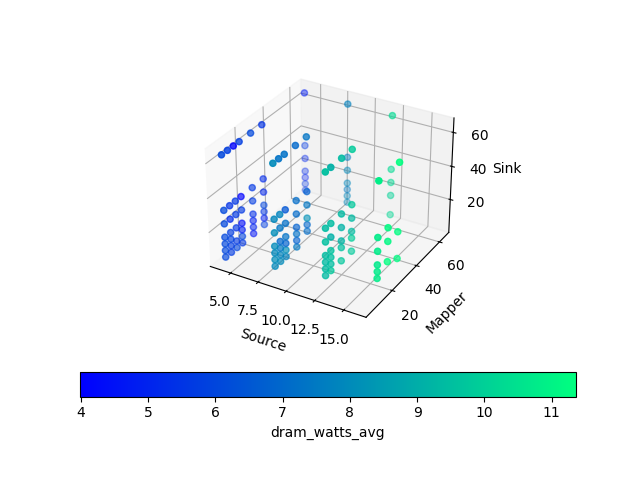

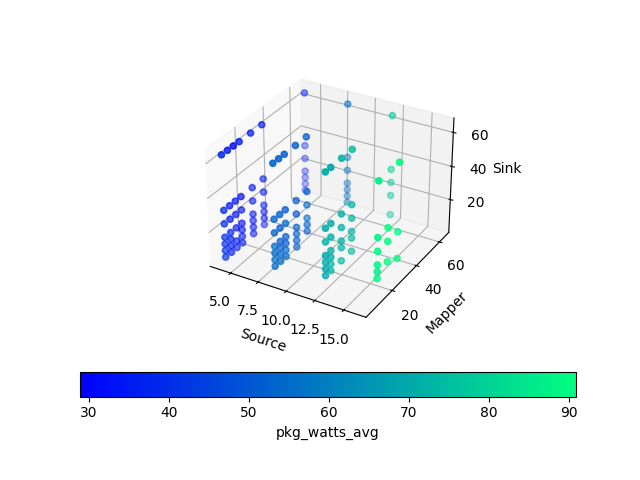

In [41]:
# Creating a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(df300['source'], df300['mapper'], df300['sink'], c=df300['pkg_watts_avg'], cmap=plt.winter())
fig.colorbar(img, orientation="horizontal", pad=0.1, label='pkg_watts_avg')
ax.set_xlabel('Source')
ax.set_ylabel('Mapper')
ax.set_zlabel('Sink')

fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')
img = ax.scatter(df300['source'], df300['mapper'], df300['sink'], c=df300['dram_watts_avg'], cmap=plt.winter())
fig2.colorbar(img, orientation="horizontal", pad=0.1, label='dram_watts_avg')
ax.set_xlabel('Source')
ax.set_ylabel('Mapper')
ax.set_zlabel('Sink')

plt.show()

# Imgproc Rate 400
## All combinations of [sources, mappers, sinks] that where SourceRecordsOutPerSecond satisfies input rate of 400

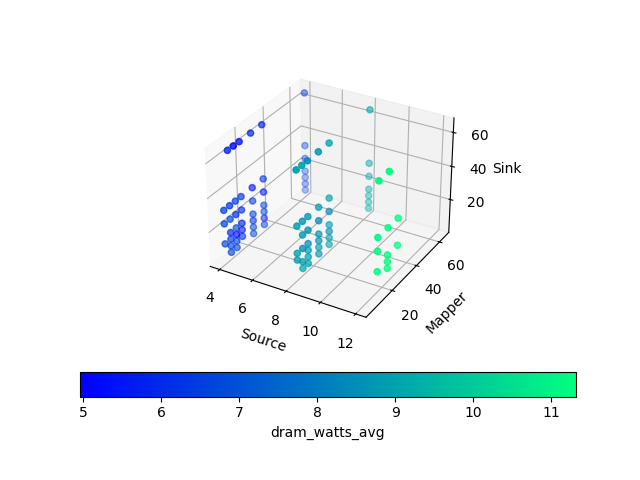

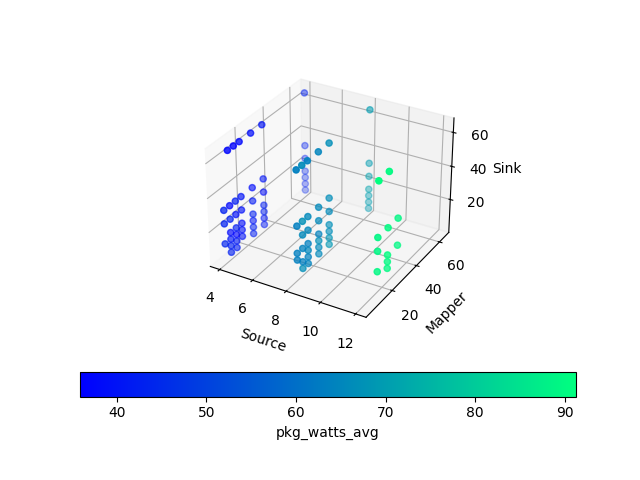

In [44]:
# Creating a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(df400['source'], df400['mapper'], df400['sink'], c=df400['pkg_watts_avg'], cmap=plt.winter())
fig.colorbar(img, orientation="horizontal", pad=0.1, label='pkg_watts_avg')
ax.set_xlabel('Source')
ax.set_ylabel('Mapper')
ax.set_zlabel('Sink')

fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')
img = ax.scatter(df400['source'], df400['mapper'], df400['sink'], c=df400['dram_watts_avg'], cmap=plt.winter())
fig2.colorbar(img, orientation="horizontal", pad=0.1, label='dram_watts_avg')
ax.set_xlabel('Source')
ax.set_ylabel('Mapper')
ax.set_zlabel('Sink')

plt.show()